In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import numpy as onp

import haiku as hk
from jax.experimental import optix

from nsec.datasets.two_moons import get_two_moons
from nsec.utils import display_score_two_moons
from nsec.models.dae.ardae import ARDAE
from nsec.normalization import SNParamsTree as CustomSNParamsTree

from functools import partial

Populating the interactive namespace from numpy and matplotlib


##  Defining the analytic target distribution

/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


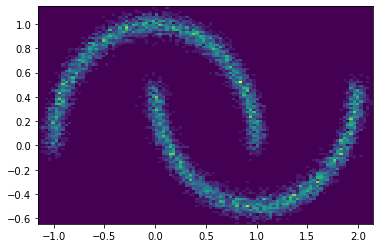

In [2]:
two_moons = get_two_moons(0.05)

rng_key = jax.random.PRNGKey(seed=0)
samps = two_moons.sample(10000, seed=rng_key)

# Plotting samples
hist2d(samps[:,0], samps[:,1],100);

In [3]:
# But now we can also compute the gradients of log p :-)
true_score = jax.vmap(jax.grad(two_moons.log_prob))

/Users/br263581/opt/anaconda3/envs/cosmo/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1601: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


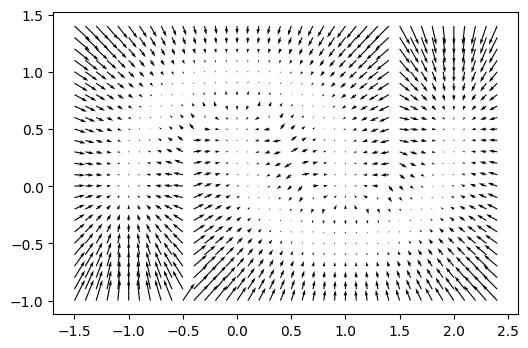

In [4]:
# Close up
figure(dpi=100)
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
g = true_score(points).reshape([len(Y), len(X),2])

quiver(X, Y, g[:,:,0], g[:,:,1])

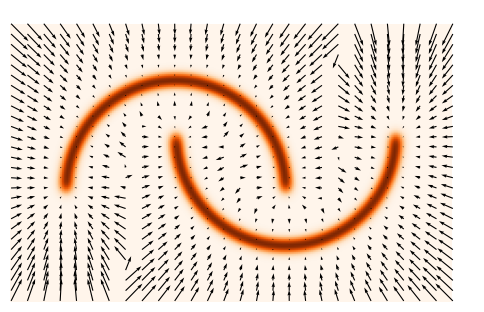

In [5]:
display_score_two_moons(true_score, two_moons, is_amortized=False, is_reg=False)

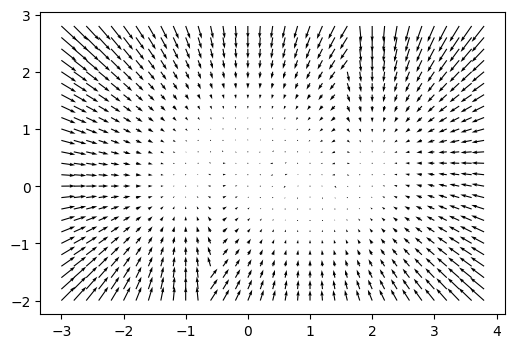

In [6]:
# Large scale
figure(dpi=100)
X = np.arange(-3, 4, 0.2)
Y = np.arange(-2, 3, 0.2)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
g = true_score(points).reshape([len(Y), len(X),2])

quiver(X, Y, g[:,:,0], g[:,:,1])

## Implementing AR-DAE 

```
class ARDAE(hk.Module):
    def __init__(self, is_training=False):
        super(ARDAE, self).__init__()
        self.is_training=is_training

    def __call__(self, x, sigma):
        sigma = sigma.reshape((-1,1))
        # Encoder
        net = hk.Linear(128)(jnp.concatenate([x, sigma],axis=1))
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(128)(net)
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(2)(net)

        # Decoder
        net = hk.Linear(128)(jnp.concatenate([net, sigma],axis=1))
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(128)(net)
        net = hk.BatchNorm(True, True, 0.9)(net, self.is_training)
        net = jax.nn.leaky_relu(net)
        net = hk.Linear(2)(net)

        return net
```

In [7]:
def forward(x, sigma, is_training=False):
    denoiser = ARDAE(is_training=is_training)
    return denoiser(x, sigma)

model_train = hk.transform_with_state(partial(forward, is_training=True))


In [8]:
batch_size = 512
delta = 0.05

def get_batch(rng_key):
    y = two_moons.sample(batch_size, seed=rng_key)
    u = onp.random.randn(batch_size, 2)
    s = delta * onp.random.randn(batch_size, 1)
    x = y + s * u
    # x is a noisy sample, y is a sample from the distribution
    # u is the random normal noise realisation
    return {'x':x, 'y':y, 'u':u, 's':s}

In [9]:
optimizer = optix.adam(1e-3)
rng_seq = hk.PRNGSequence(42)

In [10]:
@jax.jit
def loss_fn(params, state, rng_key, batch):
    res, state = model_train.apply(params,  state, rng_key, 
                                   batch['x'], batch['s'])
    loss = jnp.mean((batch['u'] + batch['s'] * res)**2)
    return loss, state

In [11]:
@jax.jit
def update(params, state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optix.apply_updates(params, updates)
    return loss, new_params, state, new_opt_state

In [12]:
params, state = model_train.init(next(rng_seq), 
                                 jnp.zeros((1, 2)), 
                                 jnp.ones((1, 1)))
opt_state = optimizer.init(params)
losses = []

In [13]:
for step in range(2000):
    batch = get_batch(next(rng_seq))
    loss, params, state, opt_state = update(params, state, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(step, loss)

0 1.0214978
100 0.9564049
200 0.9268209
300 0.8854354
400 0.90499866
500 0.88887066
600 0.84961146
700 0.884948
800 0.95935506
900 0.86726964
1000 0.835867
1100 0.8731197
1200 0.89525425
1300 0.84458125
1400 0.9049193


KeyboardInterrupt: 

In [ ]:
semilogy(np.array(losses[:]), label='loss')
legend()

In [ ]:
print(type(params))
print(params)

In [ ]:
import pickle

a = params

with open('../params/filename.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('../params/filename.pickle', 'rb') as handle:
    b = pickle.load(handle)

loaded_params = b

In [ ]:
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

model = hk.transform_with_state(partial(forward, is_training=False))
dae_score = partial(model.apply, loaded_params, state, next(rng_seq))

In [ ]:
res, state = dae_score(points, 0.0*jnp.ones((len(points),1)))

In [ ]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

In [ ]:
X = np.arange(-1.5, 2.5, 0.01)
Y = np.arange(-1, 1.5, 0.01)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
res, state = dae_score(points, jnp.zeros((len(points),1)))
g = res.reshape([len(Y), len(X),2])
imshow(np.sqrt(g[:,:,0]**2 + g[:,:,1]**2))

In [ ]:
display_score_two_moons(dae_score, two_moons, is_amortized=True, is_reg=True)

In [ ]:
X = np.arange(-3, 4, 0.2)
Y = np.arange(-2, 3, 0.2)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

res, state = dae_score(points, 0.0*jnp.ones((len(points),1)))

In [ ]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

## Adding Lipschitz regularisation

In [ ]:
def forward(x, sigma, is_training=False):
    denoiser = ARDAE(is_training=is_training)
    return denoiser(x, sigma)

model_train = hk.transform_with_state(partial(forward, is_training=True))

sn_fn = hk.transform_with_state(lambda x: CustomSNParamsTree(ignore_regex='[^?!.]*b$', val=2)(x))

In [ ]:
batch_size = 512
delta = 0.05

def get_batch(rng_key):
    y = two_moons.sample(batch_size, seed=rng_key)
    u = onp.random.randn(batch_size, 2)
    s = delta * onp.random.randn(batch_size, 1)
    x = y + s * u
    # x is a noisy sample, y is a sample from the distribution
    # u is the random normal noise realisation
    return {'x':x, 'y':y, 'u':u, 's':s}

In [ ]:
optimizer = optix.adam(1e-3)
rng_seq = hk.PRNGSequence(42)

In [ ]:
@jax.jit
def loss_fn(params, state, rng_key, batch):
    res, state = model_train.apply(params,  state, rng_key, 
                                   batch['x'], batch['s'])
    loss = jnp.mean((batch['u'] + batch['s'] * res)**2)
    return loss, state

In [ ]:
@jax.jit
def update(params, state, sn_state, rng_key, opt_state, batch):
    (loss, state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, state, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optix.apply_updates(params, updates)
    
    new_params, new_sn_state = sn_fn.apply(None, sn_state, None, new_params)
    
    return loss, new_params, state, new_sn_state, new_opt_state

In [ ]:
params, state = model_train.init(next(rng_seq), 
                                 jnp.zeros((1, 2)), 
                                 jnp.ones((1, 1)))
opt_state = optimizer.init(params)
_, sn_state = sn_fn.init(jax.random.PRNGKey(1), params)

losses = []

In [ ]:
for step in range(2000):
    batch = get_batch(next(rng_seq))
    loss, params, state, sn_state, opt_state = update(params, state, sn_state, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(step, loss)

In [ ]:
semilogy(np.array(losses[:]), label='loss')
legend()

In [ ]:
X = np.arange(-1.5, 2.5, 0.1)
Y = np.arange(-1, 1.5, 0.1)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

model_sn = hk.transform_with_state(partial(forward, is_training=False))
score_sn = partial(model_sn.apply, params, state, next(rng_seq))

In [ ]:
res, state = score_sn(points, 0.0*jnp.ones((len(points),1)))

In [ ]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

In [ ]:
display_score_two_moons(score_sn, two_moons, is_amortized=True, is_reg=True)

In [ ]:
X = np.arange(-1.5, 2.5, 0.01)
Y = np.arange(-1, 1.5, 0.01)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
res, state = score_sn(points, jnp.zeros((len(points),1)))
g = res.reshape([len(Y), len(X),2])
imshow(np.sqrt(g[:,:,0]**2 + g[:,:,1]**2))

In [ ]:
X = np.arange(-3, 4, 0.2)
Y = np.arange(-2, 3, 0.2)
points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

res, state = score_sn(points, 0.0*jnp.ones((len(points),1)))

In [ ]:
g = res.reshape([len(Y), len(X),2])
figure(figsize=(14,7))
quiver(X, Y, g[:,:,0], g[:,:,1])

In [ ]:
def display_score_error_two_moons(true_score, estimated_scores, labels, distribution=None, dpi=100, n=28, is_amortized=True, is_reg=True, scale=1, offset=[0, 0]):
    #plt.figure(dpi=dpi)
    
    #c1 = [-3, -2]
    #c2 = [4, 3]
    scale = scale
    offset = jnp.array(offset)
    
    d_offset = jnp.array([.5, .25])
    c1 = scale * (jnp.array([-.7, -0.5])) + d_offset + offset
    c2 = scale * (jnp.array([.7, 0.5])) + d_offset + offset

    #X = np.arange(c1[0], c2[0], 0.1)
    #Y = np.arange(c1[1], c2[1], 0.1)
    n = 100
    X = np.linspace(c1[0], c2[0], int(n*7/5))
    Y = np.linspace(c1[1], c2[1], n)
    if distribution:
        _x, _y = jnp.meshgrid(jnp.arange(0, len(X), 1), jnp.arange(0, len(Y), 1))
        Z = jnp.stack(jnp.meshgrid(X, Y), axis=-1).reshape((-1, 2))
        S = distribution.log_prob(Z)
        dist = jnp.exp(S.reshape((len(Y), len(X))))
    
    points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))
    true_s = true_score(points)
    true_s = true_s.reshape([len(Y), len(X),2])/jnp.linalg.norm(true_s)
    
    n_s = len(scores)
    estimated_vector_fileds = []
    errors = []

    for score in estimated_scores:
        if is_amortized:
            if is_reg:
                estimated_s, state = score(points, 0.0*jnp.ones((len(points),1)))
            else:
                estimated_s = score(points, 0.0*jnp.ones((len(points),1)))
        else:
            if is_reg:
                estimated_s, state = score(points)
            else:
                estimated_s = score(points)
        estimated_s = estimated_s.reshape([len(Y), len(X),2])/jnp.linalg.norm(estimated_s)
        
        estimated_vector_fileds.append(estimated_s)
        errors.append(jnp.linalg.norm(estimated_s - true_s, axis=2))
        
    v_min = jnp.min([jnp.min(e) for e in errors])
    v_max = jnp.max([jnp.max(e) for e in errors])

    for i in range(n_s):
        plt.subplot(n_s, 2, 2*i+1)
        plt.imshow(errors[i], origin='lower', vmin=v_min, vmax=v_max)
        plt.axis('off')
        
        plt.colorbar()
        if distribution:
            plt.contour(_x, _y, dist, levels=[1], colors='white')
        plt.title('Score error ({}), avg={:.2e}'.format(labels[i], jnp.mean(errors[i])), fontsize=9)
        
        plt.subplot(n_s, 2, 2*i+2)
        
        g = estimated_vector_fileds[i]
        plt.quiver(X[::4], Y[::4], g[::4,::4,0], g[::4,::4,1])
        #plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('error_comparison.png')    
    

In [ ]:
scores = [dae_score, score_sn]
labels = ['DAE', 'SN DAE']

In [ ]:
from nsec.utils import display_score_error_two_moons
plt.figure(dpi=100)
scale = 4
offset = [0, 0]
display_score_error_two_moons(true_score, scores, labels, distribution=two_moons, is_amortized=True, is_reg=True, scale=scale, offset=offset)

In [ ]:
plt.figure(dpi=150)
scale = 1
offset = [0, 0]
display_score_error_two_moons(true_score, scores, labels, distribution=two_moons, is_amortized=True, is_reg=True, scale=scale, offset=offset)
plt.savefig('error_comparison.png')

In [ ]:
plt.savefig('error_two_moons_zoomed.png')

In [ ]:
from nsec.models.nflow.nsf import NeuralSplineCoupling, NeuralSplineFlow

In [ ]:
def forwardNF(x):
    flow = NeuralSplineFlow()
    return flow(x)
             
model_NF = hk.transform(forwardNF, apply_rng=True)

In [ ]:
optimizer = optix.adam(1e-4)
rng_seq = hk.PRNGSequence(42)

In [ ]:
batch_size = 512

def make_samples(rng_seq, n_samples, gm):
    return gm.sample(n_samples, seed = next(rng_seq))

distribution = two_moons
def get_batch():
    x = make_samples(rng_seq, batch_size,distribution)
    return {'x': x}

In [ ]:
@jax.jit
def loss_fn(params, rng_key, batch):
    log_prob = model_NF.apply(params, rng_key, batch['x'])
    return -jnp.mean(log_prob)

@jax.jit
def update(params, rng_key, opt_state, batch):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optix.apply_updates(params, updates)
    return loss, new_params, new_opt_state

In [ ]:
params = model_NF.init(next(rng_seq), jnp.zeros((1, 2)))
opt_state = optimizer.init(params)

In [ ]:
losses = []
for step in range(2000):
    batch = get_batch()
    loss, params, opt_state = update(params, next(rng_seq), opt_state, batch)
    losses.append(loss)
    if step%100==0:
        print(loss)

In [ ]:
plot(losses)

In [ ]:
log_prob = partial(model_NF.apply, params, next(rng_seq))
log_prob(jnp.zeros(2).reshape(1,2)).shape

def log_prob_reshaped(x):
    x = x.reshape([1,-1])
    return jnp.reshape(log_prob(x), ())

score_NF = jax.vmap(jax.grad(log_prob_reshaped))

from nsec.utils import display_score_error_two_moons

scores = [score_NF, dae_score, score_sn]
labels = ['NF', 'DAE', 'SN DAE']

plt.figure(dpi=150)
scale = 4
offset = [0, 0]
display_score_error_two_moons(true_score, scores, labels, distribution=two_moons, 
                              is_amortized=True, is_reg=True, scale=scale, offset=offset, is_NF=True)
plt.savefig('method_comparison.png')

In [ ]:
scale = 3
offset = jnp.array([0., 0.])

d_offset = jnp.array([.5, .25])
c1 = scale * (jnp.array([-.7, -0.5])) + d_offset + offset
c2 = scale * (jnp.array([.7, 0.5])) + d_offset + offset

#X = np.arange(c1[0], c2[0], 0.1)
#Y = np.arange(c1[1], c2[1], 0.1)
n = 100
X = np.linspace(c1[0], c2[0], int(n*7/5))
Y = np.linspace(c1[1], c2[1], n)

points = stack(meshgrid(X, Y), axis=-1).reshape((-1, 2))

estimated_sn, state = score_sn(points, 0.0*jnp.ones((len(points),1)))
estimated_sn = estimated_sn.reshape([len(Y), len(X),2])/jnp.linalg.norm(estimated_sn)

estimated_dae, state = dae_score(points, 0.0*jnp.ones((len(points),1)))
estimated_dae = estimated_dae.reshape([len(Y), len(X),2])/jnp.linalg.norm(estimated_dae)

estimated_nf = score_NF(points)
estimated_nf = estimated_nf.reshape([len(Y), len(X),2])/jnp.linalg.norm(estimated_nf)

true_score = jax.vmap(jax.grad(two_moons.log_prob))
true_s = true_score(points)
true_s = true_s.reshape([len(Y), len(X),2])/jnp.linalg.norm(true_s)

errors_sn = jnp.linalg.norm(estimated_sn - true_s, axis=2)
errors_dae = jnp.linalg.norm(estimated_dae - true_s, axis=2)
errors_nf = jnp.linalg.norm(estimated_nf - true_s, axis=2)

errors = [errors_sn, errors_dae, errors_nf]

v_min = jnp.min([jnp.min(e) for e in errors[:-1]])
v_max = jnp.max([jnp.max(e) for e in errors[:-1]])

plt.figure(dpi=100)

plt.subplot(311)
imshow(errors_dae, origin='lower', vmin=v_min, vmax=v_max)
colorbar()

plt.subplot(312)
imshow(errors_sn, origin='lower', vmin=v_min, vmax=v_max)
colorbar()

plt.subplot(313)
imshow(errors_nf, origin='lower', vmin=v_min, vmax=v_max)
colorbar()

#plt.imshow(errors[i], origin='lower', vmin=v_min, vmax=v_max)
#plt.subplot(122)
#quiver(X[::4], Y[::4], estimated_s[::4,::4,0], estimated_s[::4,::4,1]);

In [ ]:
plt.imshow(distribution.log_prob(points).reshape([len(Y), len(X)]))
plt.colorbar()

In [ ]:
curve_error = []

estimated_sn, state = score_sn(points, 0.0*jnp.ones((len(points),1)))
estimated_sn /= np.linalg.norm(estimated_sn)

estimated_dae, state = dae_score(points, 0.0*jnp.ones((len(points),1)))
estimated_dae /= np.linalg.norm(estimated_dae)

estimated_nf = score_NF(points)
estimated_nf /= np.linalg.norm(estimated_nf)

true_s = true_score(points)
true_s /= np.linalg.norm(true_s)

error_sn = np.linalg.norm(estimated_sn - true_s, axis=1)
error_dae = np.linalg.norm(estimated_dae - true_s, axis=1)
error_nf = np.linalg.norm(estimated_nf - true_s, axis=1)

distance = distribution.log_prob(points)

argsort_distance = distance.argsort()
distance = distance[argsort_distance]
error_sn = error_sn[argsort_distance]
error_dae = error_dae[argsort_distance]
error_nf = error_nf[argsort_distance]

"""
table_sn = np.stack([distance, error_sn])
table_sn = np.sort(table_sn, 1)
table_dae = np.stack([distance, error_dae])
table_dae = np.sort(table_dae, 1)
table_nf = np.stack([distance, error_nf])
table_nf = np.sort(table_nf, 1)
"""

n_p = table_sn[0].shape[0]
r = 100
table_dae_bined = np.zeros((2, n_p//r))
d_dae = np.zeros(n_p//r)
table_sn_bined = np.zeros((2, n_p//r))
d_sn = np.zeros(n_p//r)
table_nf_bined = np.zeros((2, n_p//r))
d_nf = np.zeros(n_p//r)

for i in range(n_p//r):
    a = int(i*r)
    b = int((i+1)*r)
    table_dae_bined[0, i] = np.mean(distance[a:b])
    table_dae_bined[1, i] = np.mean(error_dae[a:b])
    d_dae[i] = np.std(error_dae[a:b])/2
    table_sn_bined[0, i] = np.mean(distance[a:b])
    table_sn_bined[1, i] = np.mean(error_sn[a:b])
    d_sn[i] = np.std(error_sn[a:b])/2
    table_nf_bined[0, i] = np.mean(distance[a:b])
    table_nf_bined[1, i] = np.mean(error_nf[a:b])
    d_nf[i] = np.std(error_nf[a:b])/2
    
plt.figure(dpi=100)

plt.plot(table_nf_bined[0,:], table_nf_bined[1,:], alpha=1, label='NSF', color='green')
plt.fill_between(table_nf_bined[0,:], table_nf_bined[1,:] - d_nf, table_nf_bined[1,:] + d_nf,
                 color='green', alpha=0.2)
plt.plot(table_dae_bined[0,:], table_dae_bined[1,:], alpha=1, label='DAE', color='red')
plt.fill_between(table_dae_bined[0,:], table_dae_bined[1,:] - d_dae, table_dae_bined[1,:] + d_dae,
                 color='red', alpha=0.2)
plt.plot(table_sn_bined[0,:], table_sn_bined[1,:], alpha=1, label='DAE w/ SN', color='blue')
plt.fill_between(table_sn_bined[0,:], table_sn_bined[1,:] - d_sn, table_sn_bined[1,:] + d_sn,
                 color='blue', alpha=0.2)

plt.ylabel('average error')
plt.xlabel('$\log p(x)$')
#plt.xscale('symlog')
plt.ylim((-.0005, .04))
#plt.xscale('log')
plt.legend()


In [ ]:
plt.figure(dpi=100)

plt.scatter(distance, error_dae, s=1, alpha=.25, label='DAE', color='red')
plt.scatter(distance, error_sn, s=1, alpha=.25, label='DAE w/ SN', color='blue')
plt.scatter(distance, error_nf, s=1, alpha=.25, label='NSF', color='green')
print(table_dae.shape)
plt.ylabel('average error')
plt.xlabel('$-\log p(x)$')
plt.xscale('symlog')
plt.ylim((-.005, .04))
#plt.yscale('simlog')
plt.legend()